In [2]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math
from patsy import dmatrices

from scipy import stats
from sklearn import datasets, linear_model
from sklearn import metrics
import statsmodels.formula.api as smh
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

import sys
reload(sys)
sys.setdefaultencoding('utf8')

%matplotlib inline
import requests

Trying to Understand What Factors Most Influence Ratings: A comparison between the best movies ever and the worst movies ever, according to IMDb.com

Install IMDb API and pull information for Top 250 movies

In [3]:
!pip install imdbpie

In [4]:
from imdbpie import Imdb
imdb = Imdb(anonymize=True)

In [5]:
df = pd.DataFrame.from_dict(imdb.top_250())

In [6]:
df.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1680298,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1149612,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,786230,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1665324,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,859974,8.9,tt0108052,Schindler's List,feature,1993


Clean the Title field to be turned into list and fed into JSON code. This will pull all relevant information on Top 250 movies to be used in analysis

In [7]:
df['title_link'] = df['title'].replace(' ','+',regex=True)
df['title_link'] = df['title_link'].replace(',','',regex=True)

In [8]:
titles = df['title_link'].tolist()

In [9]:
import json
import urllib2

top250 = pd.DataFrame(columns = ['Plot','Rated','Response','Language','Title','Country','Writer','Metascore',
                                 'imdbRating','Director','Released','Actors','Year','Genre','Awards','Runtime','Type',
                                 'Poster','imdbVotes','imdbID'])
print top250

for i in titles:
    url = "http://www.omdbapi.com/?t={0}&plot=short&r=json".format(i)
    data = json.load(urllib2.urlopen(url))
    df_i = pd.DataFrame.from_dict(data, orient='index')
    df_i = df_i.T
    top250 = top250.append(df_i)

In [10]:
# Drop columns that will not be used in analysis
top250_v2 = top250.drop(top250.columns[[0,3,7,9,12,15,16,18]], axis=1)

In [11]:
# Convert Year, imdbRating, and imdbVotes fields to numeric
top250_v2['Year'] = top250_v2['Year'].convert_objects(convert_numeric=True)
top250_v2['imdbRating'] = top250_v2['imdbRating'].convert_objects(convert_numeric=True)
top250_v2['imdbVotes'] = top250_v2['imdbVotes'].replace(',','',regex=True)
top250_v2['imdbVotes'] = top250_v2['imdbVotes'].convert_objects(convert_numeric=True)

In [12]:
top250_v2['Error'].value_counts()

Must provide more than one character.    1
Name: Error, dtype: int64

JSON cannot find one movie - I will drop this

In [13]:
top250_v2.head(3)

,Awards,Country,Error,Genre,Language,Plot,Rated,Released,Runtime,Title,Year,imdbRating,imdbVotes
0,Nominated for 7 Oscars. Another 15 wins & 21 n...,USA,NaN,"Crime, Drama",English,Two imprisoned men bond over a number of years...,R,14 Oct 1994,142 min,The Shawshank Redemption,1994.0,9.3,1668622.0
0,Won 3 Oscars. Another 23 wins & 27 nominations.,USA,NaN,"Crime, Drama","English, Italian, Latin",The aging patriarch of an organized crime dyna...,R,24 Mar 1972,175 min,The Godfather,1972.0,9.2,1140778.0
0,Won 6 Oscars. Another 10 wins & 20 nominations.,USA,NaN,"Crime, Drama","English, Italian, Spanish, Latin, Sicilian",The early life and career of Vito Corleone in ...,R,20 Dec 1974,202 min,The Godfather: Part II,1974.0,9.0,784338.0


Scrape all worst movie titles

In [14]:
import bs4
from bs4 import BeautifulSoup

In [15]:
url = 'http://www.imdb.com/chart/bottom?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=2417962742&pf_rd_r=1DSDJRQVZS781GZZNZRV&pf_rd_s=right-4&pf_rd_t=15506&pf_rd_i=moviemeter&ref_=chtmvm_ql_6'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')
response

titles=[]
## Titles from bottom 100 list ##
for title in soup.findAll('td', class_='titleColumn'):
    titles.append(title.text.strip())

bottom_titles = pd.DataFrame(titles, columns=['title'])

Clean scraping output so only the Movie title is left in a new "title2" field

In [16]:
bottom_titles['title2'] = bottom_titles['title'].astype(str).str[:-6]
bottom_titles['title2'] = bottom_titles['title2'].replace('\n','',regex=True)
bottom_titles['title2'] = bottom_titles['title2'].apply(lambda x: (x.lstrip('0123456789.- ')))
bottom_titles.head()

,title,title2
0,1.\n Code Name: K.O.Z.\n(2015),Code Name: K.O.Z.
1,2.\n Saving Christmas\n(2014),Saving Christmas
2,3.\n Superbabies: Baby Geniuses 2\n(2004),Superbabies: Baby Geniuses 2
3,4.\n Daniel der Zauberer\n(2004),Daniel der Zauberer
4,5.\n Manos: The Hands of Fate\n(1966),Manos: The Hands of Fate


In [17]:
# Continue to clean Title field
bottom_titles['title2'] = bottom_titles['title2'].replace(' ','+',regex=True)
bottom_titles['title2'] = bottom_titles['title2'].replace(',','',regex=True)
bottom_titles['title2'] = bottom_titles['title2'].replace(':','',regex=True)
bottom_titles['title2'] = bottom_titles['title2'].replace('!','',regex=True)
bottom_titles['title2'] = bottom_titles['title2'].replace("'",'',regex=True)
bottom_titles['title2'] = bottom_titles['title2'].replace('-','',regex=True)

In [18]:
# Using the same methodology as above, create list of movie titles that will run through JSON code
bottom_titles_list = bottom_titles['title2'].tolist()

In [19]:
bottom_titles.head(3)

,title,title2
0,1.\n Code Name: K.O.Z.\n(2015),Code+Name+K.O.Z.
1,2.\n Saving Christmas\n(2014),Saving+Christmas
2,3.\n Superbabies: Baby Geniuses 2\n(2004),Superbabies+Baby+Geniuses+2


In [20]:
bottom100 = pd.DataFrame(columns = ['Plot','Rated','Response','Language','Title','Country','Writer','Metascore',
                                 'imdbRating','Director','Released','Actors','Year','Genre','Awards','Runtime','Type',
                                 'Poster','imdbVotes','imdbID'])
print bottom100

for i in bottom_titles_list:
    url = "http://www.omdbapi.com/?t={0}&plot=short&r=json".format(i)
    data = json.load(urllib2.urlopen(url))
    df_i = pd.DataFrame.from_dict(data, orient='index')
    df_i = df_i.T
    bottom100 = bottom100.append(df_i)

In [21]:
bottom100.head(3)

,Actors,Awards,Country,Director,Error,Genre,Language,Metascore,Plot,Poster,...,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Cem Kurtoglu, Hazim Körmükçü, Tolga Karel, Hak...",N/A,Turkey,Celal Çimen,NaN,"Crime, Mystery",Turkish,N/A,Political and social processes in recent and c...,http://ia.media-imdb.com/images/M/MV5BMDhkOTQz...,...,13 Feb 2015,True,114 min,Code Name: K.O.Z.,movie,N/A,2015,tt4458206,1.6,"17,920"
0,"Kirk Cameron, Darren Doane, Bridgette Cameron,...",4 wins & 2 nominations.,USA,Darren Doane,NaN,"Comedy, Family",English,18,Kirk is enjoying the annual Christmas party ex...,http://ia.media-imdb.com/images/M/MV5BMTc3MTc3...,...,14 Nov 2014,True,80 min,Saving Christmas,movie,"Darren Doane, Cheston Hervey",2014,tt4009460,1.5,"11,195"
0,"Jon Voight, Scott Baio, Vanessa Angel, Skyler ...",5 nominations.,"Germany, UK, USA",Bob Clark,NaN,"Comedy, Family, Sci-Fi",English,9,A group of smart-talking toddlers find themsel...,http://ia.media-imdb.com/images/M/MV5BNjY4NjM3...,...,27 Aug 2004,True,88 min,Superbabies: Baby Geniuses 2,movie,"Steven Paul (story), Gregory Poppen (screenplay)",2004,tt0270846,1.9,"24,996"


In [22]:
bottom100.info()

In [23]:
# Keep relevant columns so that the Top 250 and Bottom 100 datasets can be stacked
bottom100_v2 = bottom100.drop(bottom100.columns[[0,3,7,9,12,15,16,18]], axis=1)

In [24]:
# Convert Year, imdbRating, and imdbVotes to numeric
bottom100_v2['Year'] = bottom100_v2['Year'].convert_objects(convert_numeric=True)
bottom100_v2['imdbRating'] = bottom100_v2['imdbRating'].convert_objects(convert_numeric=True)
bottom100_v2['imdbVotes'] = bottom100_v2['imdbVotes'].replace(',','',regex=True)
bottom100_v2['imdbVotes'] = bottom100_v2['imdbVotes'].convert_objects(convert_numeric=True)

In [25]:
top250_v2.head(3)

,Awards,Country,Error,Genre,Language,Plot,Rated,Released,Runtime,Title,Year,imdbRating,imdbVotes
0,Nominated for 7 Oscars. Another 15 wins & 21 n...,USA,NaN,"Crime, Drama",English,Two imprisoned men bond over a number of years...,R,14 Oct 1994,142 min,The Shawshank Redemption,1994.0,9.3,1668622.0
0,Won 3 Oscars. Another 23 wins & 27 nominations.,USA,NaN,"Crime, Drama","English, Italian, Latin",The aging patriarch of an organized crime dyna...,R,24 Mar 1972,175 min,The Godfather,1972.0,9.2,1140778.0
0,Won 6 Oscars. Another 10 wins & 20 nominations.,USA,NaN,"Crime, Drama","English, Italian, Spanish, Latin, Sicilian",The early life and career of Vito Corleone in ...,R,20 Dec 1974,202 min,The Godfather: Part II,1974.0,9.0,784338.0


In [26]:
bottom100_v2.head(3)

,Awards,Country,Error,Genre,Language,Plot,Rated,Released,Runtime,Title,Year,imdbRating,imdbVotes
0,N/A,Turkey,NaN,"Crime, Mystery",Turkish,Political and social processes in recent and c...,N/A,13 Feb 2015,114 min,Code Name: K.O.Z.,2015.0,1.6,17920.0
0,4 wins & 2 nominations.,USA,NaN,"Comedy, Family",English,Kirk is enjoying the annual Christmas party ex...,PG,14 Nov 2014,80 min,Saving Christmas,2014.0,1.5,11195.0
0,5 nominations.,"Germany, UK, USA",NaN,"Comedy, Family, Sci-Fi",English,A group of smart-talking toddlers find themsel...,PG,27 Aug 2004,88 min,Superbabies: Baby Geniuses 2,2004.0,1.9,24996.0


Create master movies dataset

In [27]:
all_movies = pd.concat([top250_v2,bottom100_v2])

Perform various data checks on master dataset

In [28]:
all_movies['Rated'].value_counts()

R            121
PG            56
PG-13         51
NOT RATED     38
N/A           23
G             14
UNRATED       13
APPROVED      12
PASSED         3
X              1
TV-MA          1
M              1
Name: Rated, dtype: int64

In [29]:
all_movies['Year'].median()

1994.0

In [30]:
all_movies['imdbRating'].median()

8.2

Create Dummies and alternate model features

In [31]:
all_movies['Rating_dummy'] = np.where(all_movies['Rated']=='R', 1, 0)

In [32]:
all_movies['length'] = all_movies['Runtime']
all_movies['length'] = all_movies['length'].astype(str).replace(' min','',regex=True)
all_movies['length'] = all_movies['length'].convert_objects(convert_numeric=True)

In [33]:
all_movies['length'].median()

116.0

In [35]:
# Remove movies that were not found
all_movies_v2 = all_movies[pd.notnull(all_movies['Language'])]

In [36]:
# Create count for the number of languages spoken in a movie
all_movies_v2['lang_count'] = all_movies_v2['Language'].apply(lambda x: str.count(str(x).encode('ascii', 'ignore'), ',')+1)

In [37]:
# Create count for the number of genres the movie identifies with
all_movies_v2['genre_count'] = all_movies_v2['Genre'].apply(lambda x: str.count(str(x).encode('ascii', 'ignore'), ',')+1)

In [38]:
# Create flag for whether the movie was released during "Oscar Season"
def oscar_bait(x):
    if 'Oct' in x:
        return 1
    elif 'Nov' in x:
        return 1
    elif 'Dec' in x:
        return 1
    else:
        return 0

In [39]:
all_movies_v2['oscar_bait_flag'] = all_movies_v2['Released'].apply(oscar_bait)

In [40]:
# Create target variable
all_movies_v2['top250_flag'] = all_movies_v2['imdbRating'].apply(lambda x: 1 if x > 7 else 0)

In [41]:
# Remove movies with obviously incorrect imdbRatings from scraping issue
all_movies_v2 = all_movies_v2[((all_movies_v2['imdbRating'] < 3) | (all_movies_v2['imdbRating'] > 7))]

Visualize the data

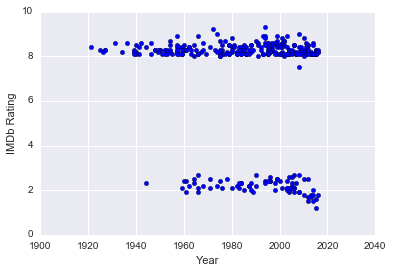

In [79]:
# Year vs. Rating scatterplot
plt.scatter(all_movies_v2['Year'],all_movies_v2['imdbRating'])
plt.xlabel('Year')
plt.ylabel('IMDb Rating')

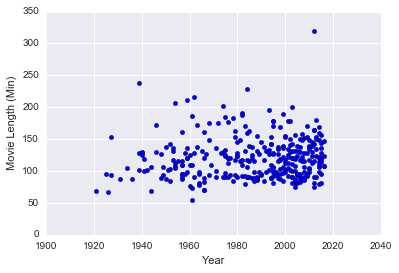

In [76]:
# Year vs. Length scatterplot
plt.scatter(all_movies_v2['Year'],all_movies_v2['length'])
plt.xlabel('Year')
plt.ylabel('Movie Length (Min)')

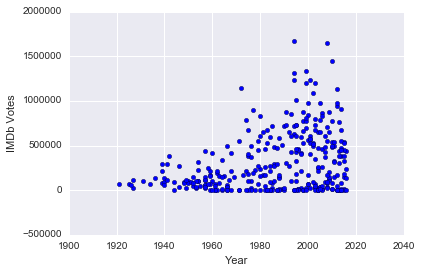

In [77]:
# Year vs. Votes scatterplot 
plt.scatter(all_movies_v2['Year'],all_movies_v2['imdbVotes'])
plt.xlabel('Year')
plt.ylabel('IMDb Votes')

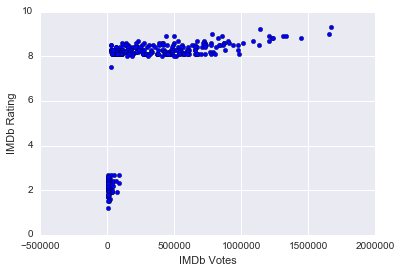

In [78]:
# Votes vs. IMDb Rating scatterplot
plt.scatter(all_movies_v2['imdbVotes'],all_movies_v2['imdbRating'])
plt.xlabel('IMDb Votes')
plt.ylabel('IMDb Rating')

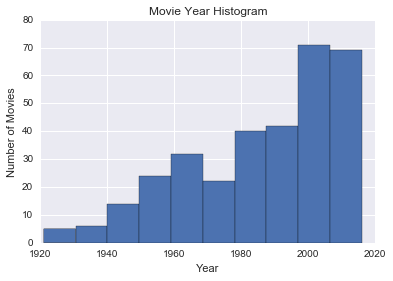

In [46]:
# Year Histogram
all_movies_v2['Year'].hist()
plt.ylabel('Number of Movies')
plt.xlabel('Year')
plt.title('Movie Year Histogram')

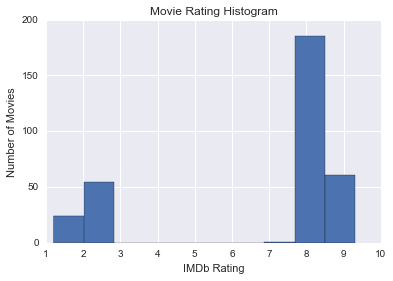

In [47]:
# Rating Histogram
all_movies_v2['imdbRating'].hist()
plt.ylabel('Number of Movies')
plt.xlabel('IMDb Rating')
plt.title('Movie Rating Histogram')

MODEL TRIALS

In [84]:
# Set Features and Target
X = all_movies_v2.drop(all_movies_v2.columns[[0,1,2,3,4,5,6,7,8,9,11,18]], axis=1)
y = all_movies_v2['top250_flag']

In [85]:
# Set up Train, Test, Split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [86]:
# Run DecisionTreeClassifier Model:
from sklearn.tree import DecisionTreeClassifier
treeclass = DecisionTreeClassifier(random_state=1)
treeclass.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [87]:
# Predict on test Using DecisionTreeClassifier Model
preds = treeclass.predict(X_test)

In [88]:
# Create confusion matrix using Test set vs Predicted
cm = confusion_matrix(y_test, preds)
cm

array([[20,  3],
       [ 0, 75]])

In [89]:
# Print Cross Val Score
cross_val_score(treeclass, X, y, cv=10, n_jobs=-1).mean()

0.96295515640273721

In [90]:
# Try same DecisionTreeModel using bagging
treeclass = DecisionTreeClassifier()
bagger = BaggingClassifier(treeclass)

In [91]:
# Fit bagger on train data
bagger.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [92]:
# Predict bagger on test dataset
bagger_preds = bagger.predict(X_test)

In [93]:
# Create bagger confusion matrix
cm_bagger = confusion_matrix(y_test, bagger_preds)
cm_bagger

array([[21,  2],
       [ 0, 75]])

In [94]:
# Print bagger cross val score
cross_val_score(bagger, X, y, cv=10, n_jobs=-1).mean()

0.96608015640273714

In [95]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [96]:
# Use RandomForest and ExtraTrees Models
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

Fit Random Forest Model on Train/Test sets

In [97]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
rf_preds = rf.predict(X_test)

In [99]:
cm_rf = confusion_matrix(y_test, rf_preds)
cm_rf

array([[22,  1],
       [ 0, 75]])

In [100]:
cross_val_score(rf, X, y, cv=10, n_jobs=-1).mean()

0.97536656891495599

In [106]:
# Print feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
imdbVotes,0.603647
length,0.210050
Year,0.080070
lang_count,0.072764
genre_count,0.022118
oscar_bait_flag,0.008785
Rating_dummy,0.002566


Fit Extra Trees Model on Train/Test sets

In [101]:
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [103]:
et_preds = et.predict(X_test)

In [104]:
cm_et = confusion_matrix(y_test, et_preds)
cm_et

array([[22,  1],
       [ 0, 75]])

In [105]:
cross_val_score(et, X, y, cv=10, n_jobs=-1).mean()

0.95992485337243405

In [107]:
feature_importances = pd.DataFrame(et.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
imdbVotes,0.454534
length,0.184652
lang_count,0.180314
Year,0.117288
genre_count,0.037078
oscar_bait_flag,0.015112
Rating_dummy,0.011022


Run all models again without imdbVotes variable because of potential multicollinearity between year/imdbVotes and imdbRating/imdbVotes

In [112]:
# Set Features and Target
X_v2 = X.drop(X.columns[1], axis=1)
y = all_movies_v2['top250_flag']

In [113]:
# Set up Train, Test, Split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_v2, y, test_size= 0.3, random_state=42)

In [116]:
# Run DecisionTreeClassifier Model:
from sklearn.tree import DecisionTreeClassifier
treeclass_v2 = DecisionTreeClassifier(random_state=1)
treeclass_v2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [117]:
# Predict Using DecisionTreeClassifier Model
preds_v2 = treeclass_v2.predict(X_test)

In [118]:
# Create confusion matrix using Test set vs Predicted
cm_v2 = confusion_matrix(y_test, preds_v2)
cm_v2

array([[16,  7],
       [ 4, 71]])

In [119]:
# Print Cross Val Score
cross_val_score(treeclass, X_v2, y, cv=10, n_jobs=-1).mean()

0.88300036656891501

In [120]:
# Try same DecisionTreeModel using bagging
bagger_v2 = BaggingClassifier(treeclass_v2)

In [121]:
bagger_v2.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [122]:
bagger_preds_v2 = bagger_v2.predict(X_test)

In [123]:
cm_bagger_v2 = confusion_matrix(y_test, bagger_preds_v2)
cm_bagger_v2

array([[18,  5],
       [ 3, 72]])

In [124]:
cross_val_score(bagger_v2, X_v2, y, cv=10, n_jobs=-1).mean()

0.87117546432062554

In [125]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [126]:
# Use RandomForest and ExtraTrees Models
rf_v2 = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et_v2 = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

In [127]:
rf_v2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [128]:
rf_preds_v2 = rf_v2.predict(X_test)

In [129]:
cm_rf_v2 = confusion_matrix(y_test, rf_preds_v2)
cm_rf_v2

array([[17,  6],
       [ 3, 72]])

In [130]:
cross_val_score(rf_v2, X_v2, y, cv=10, n_jobs=-1).mean()

0.89854288856304976

In [132]:
feature_importances = pd.DataFrame(rf_v2.feature_importances_,
                                   index = X_v2.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
length,0.573793
Year,0.235194
lang_count,0.101699
Rating_dummy,0.034230
genre_count,0.033517
oscar_bait_flag,0.021567


In [133]:
et_v2.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [134]:
et_preds_v2 = et_v2.predict(X_test)

In [135]:
cm_et_v2 = confusion_matrix(y_test, et_preds_v2)
cm_et_v2

array([[16,  7],
       [ 5, 70]])

In [136]:
cross_val_score(et_v2, X_v2, y, cv=10, n_jobs=-1).mean()

0.85221774193548383

In [143]:
et_score = cross_val_score(et_v2, X_v2, y, cv=10, n_jobs=-1).mean()

In [137]:
feature_importances = pd.DataFrame(et_v2.feature_importances_,
                                   index = X_v2.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
length,0.467704
Year,0.208964
lang_count,0.205083
genre_count,0.060712
Rating_dummy,0.032074
oscar_bait_flag,0.025463


Even though the model performs worse (as measured by cross val score) without the imdbVotes feature, I have more confidence that the model does not suffer from multicollinearity.

In [149]:
# Print some summary stats for feature variables split by target variable
pd.pivot_table(all_movies_v2, index=['top250_flag'], values=['length','Year','lang_count','imdbVotes','genre_count',
                                                            'Rating_dummy','oscar_bait_flag'],
               aggfunc=np.mean)

,Rating_dummy,Year,genre_count,imdbVotes,lang_count,length,oscar_bait_flag
top250_flag,,,,,,,
0,0.243590,1992.679487,2.128205,13032.974359,1.012821,92.397436,0.230769
1,0.412955,1984.356275,2.461538,399999.093117,1.854251,129.016194,0.283401
